In [17]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [18]:
'''
Loading
'''

stations = nice.graph.graph_from_json('Data/corridor_stations.json')
places = nice.graph.graph_from_json('Data/places_50k.json')
atlas = nice.graph.graph_from_json('Data/reduced_atlas.json')

In [101]:
'''
Place and Station Adjacency
'''
deep_reload(nice)

graph = nice.graph.supergraph([places, stations])

kw = {
    'objective': 'time',
}

graph = nice.graph.adjacency(atlas, graph, **kw)
graph = nx.DiGraph(graph)

nice.graph.graph_to_json(graph, 'Data/graph.json')

 [--------->] (569/569) 100.00%, 22.10 it/s, 25.79 s elapsed, 0.00 s remaining

In [19]:
graph = nice.graph.graph_from_json('Data/graph.json')

In [20]:
nodes = [k for k, n in graph._node.items() if n.get('population', np.inf) >= 1e5]

graph = nice.graph.subgraph(graph, nodes)

In [21]:
'''
Energy
'''

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['energy'] = 500 * edge['distance']

'''
Places and Stations
'''

places = [k for k, n in graph._node.items() if 'station' not in k]
stations = [k for k, n in graph._node.items() if 'station' in k]

In [22]:
'''
Subgraphs
'''

nodes = (
    [k for k, n in graph._node.items() if n.get('network', 'Tesla') == 'Tesla']
)

graph_nacs = nice.graph.subgraph(graph, nodes)

print(graph_nacs.number_of_nodes(), graph_nacs.number_of_edges())

nodes = (
    [k for k, n in graph._node.items() if n.get('network', '') != 'Tesla']
)

graph_ccs = nice.graph.subgraph(graph, nodes)

print(graph_ccs.number_of_nodes(), graph_ccs.number_of_edges())

122 14884
419 175561


In [345]:
nice.graph.graph_to_json(graph, 'Data/graph_100k.json')
nice.graph.graph_to_json(graph_ccs, 'Data/graph_ccs_100k.json')
nice.graph.graph_to_json(graph_nacs, 'Data/graph_nacs_100k.json')

In [23]:
'''
Creating a Vehicle
'''
deep_reload(nice)

kw = {
    'capacity': 75 * 3.6e6,
    'soc_min': .5,
}

vehicle = nice.optimization.Vehicle(**kw)

graph = vehicle.trim(graph, places + stations)

graph.number_of_nodes(), graph.number_of_edges()

(466, 63964)

In [24]:
'''
Paths
'''

deep_reload(nice)

paths = nice.optimization.get_paths(
    graph, terminals = places, k = 50, weight = 'time',
)

 [----------->] (75/75) 100.00%, 0.08 it/s, 979.61 s elapsed, 0.00 s remaining

In [25]:
'''
Paths CCS
'''


deep_reload(nice)

paths_ccs = nice.optimization.get_paths(
    graph_ccs, terminals = places, k = 15, weight = 'time',
)

 [---------->] (75/75) 100.00%, 0.03 it/s, 2898.76 s elapsed, 0.00 s remaining

In [26]:
'''
Paths NACS
'''

deep_reload(nice)

paths_nacs = nice.optimization.get_paths(
    graph_nacs, terminals = places, k = 15, weight = 'time',
)

 [------------>] (75/75) 100.00%, 0.86 it/s, 88.45 s elapsed, 0.00 s remaining

In [337]:
for path in paths:

    _ = path.pop('_class')

In [27]:
with open('Data/paths_100k_50.json', 'w') as file:

    json.dump(paths, file)

with open('Data/paths_ccs_100k_50.json', 'w') as file:

    json.dump(paths_ccs, file)

with open('Data/paths_nacs_100k_50.json', 'w') as file:

    json.dump(paths_nacs, file)

In [234]:
with open('Data/paths_100k.json', 'r') as file:

    paths = json.load(file)

(array([  756.,     0.,     0.,     0.,     0., 73744.,     0.,     0.,
            0.,   752.]),
 array([2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <BarContainer object of 10 artists>)

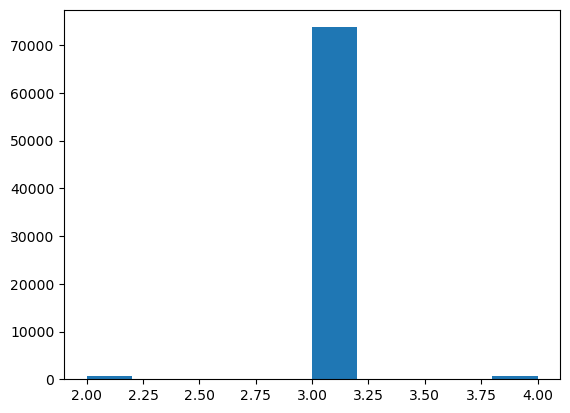

In [232]:
plt.hist([len(p['path']) for p in paths])

In [306]:
'''
Places
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
    # 'friction_function': lambda x: 1,
}

graph = nice.demand.demand(graph, places, **kw)

In [308]:
sum_demand = 0

for source, node in graph._node.items():
    if 'CA' in source:
        for d, f in node['flows'].items():

            sum_demand += f

sum_demand

1.0000000000000016

In [309]:
'''
Stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))

for station in stations:

    node = graph._node[station]

    power = node['power_kw'] * 1e3
    m = 1 / (energy / power)
    queue = nice.queue.Queue(m = m, rho = rho, c = c)

    c = [node['port_count']]
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes)
    graph._node[station]['expenditures'] = [0]

In [310]:
'''
Adding classes
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

In [311]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Sets Built: 0.05718231201171875
Parameters Built: 1.2800664901733398
Variables Built: 4.313475608825684
Constraints Built: 0.47793054580688477
Expenditure Built: 0.02486276626586914
Objective Built: 0.31667256355285645


In [321]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        # '_name': 'cbc',
        '_name': 'appsi_highs',
        'time_limit': 10 * 6,
        # 'penalty': 10,
        # 'sec': 10,
        # 'ratio': .000001,
    },
}

network.model.scale = 1e0
network.model.penalty = 1
# network.model.expenditure = 1e3
# network.model.expenditure_cost = 50 * 0
network.solve(**kw)
solution = network.solution
# solution = nice.optimization.solution_atlas(
#     network.solution, atlas, fields = ['volume']
# )

Problem Solved: 3.6720526218414307
Results Collected: 0.6688158512115479


In [322]:
import pyomo.environ as pe

pe.value(network.model.objective)

25.3170574988305

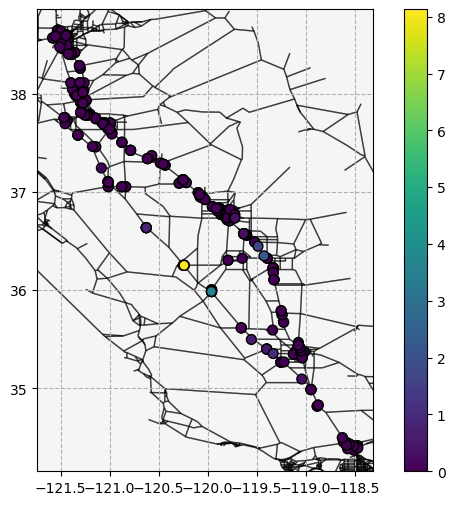

In [323]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

eps = 0

s_nodes = [k for k, n in solution._node.items() if n.get('volume', 0) > 0]
s_nodes = [k for k, n in solution._node.items() if n.get('selection', 0) > 0]
s_edges = (
    [(s, t) for s, a in solution._adj.items() \
     for t, e in a.items() if e.get('volume', 0) > eps]
)

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600

kw = {
    'nodes': {
        'selection': list(stations),
        'field': 'delay',
        'colorbar': {},
        'plot': {
            's': 50,
            'zorder': 2,
            'ec': 'k',
            # 'fc': 'lightgray',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'field': 'population',
        'colorbar': {},
        'plot': {
            's': 50,
            'fc': 'k',
            'ec': 'k',
            'zorder': 3,
            'marker': 'H',
        },
    },     
}
    
# _ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': .5,
            'zorder': 0,
        },
    },     
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'plot': {
        'horizontalalignment': 'center',
        'verticalalignment': 'center',
        'fontstyle': 'italic',
        'fontweight': 'roman',
        'fontfamily': 'monospace',
    },
    'selection': s_nodes,
    'field': 'selection',
}

# _ = nice.plot.plot_labels(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')

In [305]:
500 / 3300 * 200000

30303.030303030304

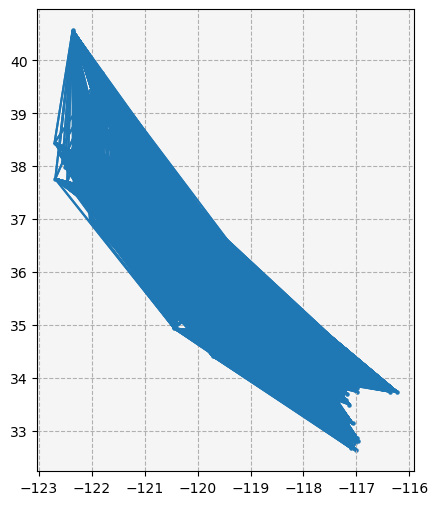

In [138]:
fig, ax = plt.subplots(figsize = (8, 6))

kw = {
    'nodes': {
        'plot': {
            's': 5,
        },
    },
    'edges': {},
}

_ = nice.plot.plot_graph(graph, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

ax.set_aspect('equal')